In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import time


class FreeFermionSystem:
    def __init__(self, L, state_name:str='bipartite_state', spin:str='spinless', filled=None):
        """
        生成特定填充的实空间初态
        
        依据
        `Cor_{ij} = < c^\\dagger_i c_j > = \\sum_{\\alpha} \\phi^*_\\alpha (i) \\phi_\\alpha (j) `
        但是其实后面算Cor的时候，复共轭在后者而不是前者  # 这是个厄米矩阵，取复共轭不影响本征值，只会改变本征矢量
        """
        if not filled is None:
            init_state = np.zeros((L, len(filled)), dtype=np.complex128)
            for i, idx in enumerate(filled):
                init_state[idx, i] = 1
            self.psi = init_state
            return

        if spin == 'spinless':
            length = L
            dis = 1
            start = 0
        elif spin == 'up':
            length = 2 * L
            dis = 2
            start = 1
        elif spin == 'down':
            length = 2 * L
            dis = 2
            start = 0
        init_state = np.zeros((length, length // 2 // dis), dtype=np.complex128)
        if state_name == 'bipartite_state':
            for i in range(length // 2 // dis):
                init_state[start + i * dis, i] = 1
        elif state_name == 'neel_state':
            for i in range(length // 2 // dis):
                init_state[start + i * 2 * dis, i] = 1
        else:
            print("Error! ")
            return
        self.psi = init_state
        return

    def evol_sys(self, H_evo, t):
        self.psi = expm( - 1j * H_evo * t) @ self.psi
        
    def entropy(self, subsys):
        """
        subsys: np.array, list
        """
        Cor = self.psi @ self.psi.conj().T
        Cor_subsys = Cor[subsys, :][:, subsys]
        xi, _ = np.linalg.eig(Cor_subsys)
        ee = np.nansum( - xi * np.log(xi) - (1 - xi) * np.log(1 - xi))
        return ee
    
    def entropy_density(self, subsys):
        """
        subsys: np.array, list
        """
        Cor = self.psi @ self.psi.conj().T
        Cor_subsys = Cor[subsys, :][:, subsys]
        xi, _ = np.linalg.eig(Cor_subsys)
        ee = np.nansum( - xi * np.log(xi) - (1 - xi) * np.log(1 - xi)) / len(subsys)
        return ee


/tmp/ipykernel_1267332/552161923.py:23: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  if np.in1d(L//2, filled_indices) == False:  # 这也是用来建立纠缠的。如果第 L//2 个 site 无占据，则参考比特有占据，反之则无
/tmp/ipykernel_1267332/552161923.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  SIC_array[i, j, x] = S_E + S_R - S_ER


ldb = 1.30 (1 / 1)


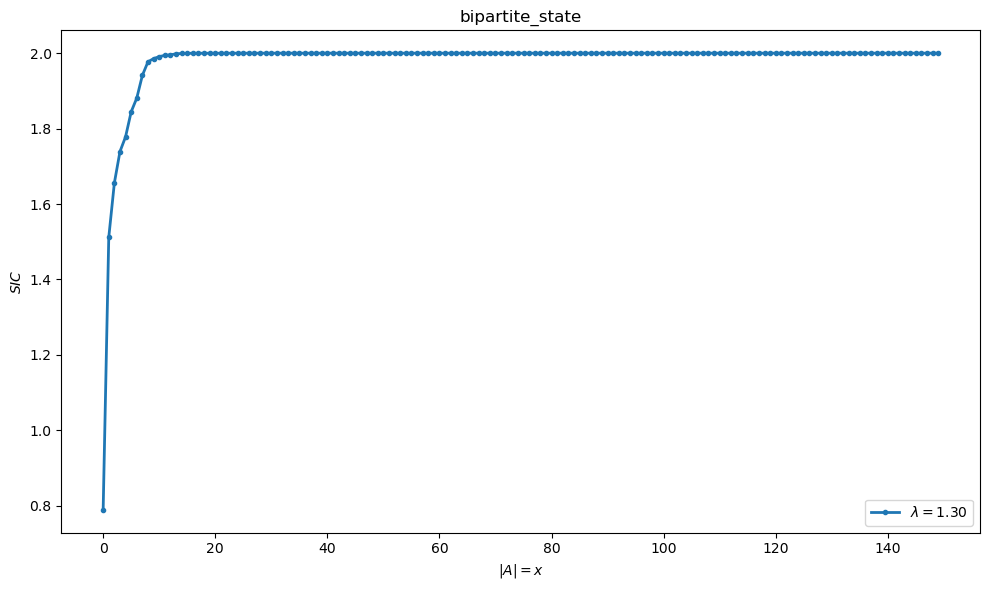

elapsed time: 85.7 s


In [ ]:
def gen_H_entangle(L):
    H = np.zeros((L + 1, L + 1), dtype=np.complex128)

    H[L//2, L] = 1
    H[L, L//2] = 1
    return H

def gen_H_GAA_real(L, t, lbd, a, b, phi):
    H = np.zeros((L + 1, L + 1), dtype=np.complex128)
    
    for i in range(L-1):
        H[i, i+1] = t
        H[i+1, i] = t
    for i in range(L):
        H[i, i] = 2 * lbd * np.cos(2*np.pi*i*b+phi) / (1-a*np.cos(2*np.pi*i*b+phi))
    return H


def cal_SIC_of_x(state_name, L, t, lbd_array, a, b, phi, pre, steps, dt, f):
    H_ent = gen_H_entangle(L)
    filled_indices = np.arange(0 , L//f)
    # filled_indices = np.arange(L//f, L)
    if np.in1d(L//2, filled_indices) == False:  # 这也是用来建立纠缠的。如果第 L//2 个 site 无占据，则参考比特有占据，反之则无
        filled_indices = np.append(filled_indices, [L])

    if state_name != "random_state":
               
        SIC_array = np.zeros((len(lbd_array), steps, L//2))
        for i, lbd in enumerate(lbd_array):
            print(f"lbd = {lbd:.2f} ({i + 1} / {len(lbd_array)})")
            
            H_evo = gen_H_GAA_real(L, t, lbd, a, b, phi)
            system = FreeFermionSystem(L + 1, filled=filled_indices)
            system.evol_sys(H_ent, np.pi/4)
            system.evol_sys(H_evo, pre)

            random_array = np.random.rand(steps)
            for j in range(steps):
                for x in range(L//2):
                    E_list = np.arange(L//2-x, L//2+x+1, 1)
                    S_E = system.entropy(E_list)
                    S_R = system.entropy([L])
                    S_ER = system.entropy(np.append(E_list, L))
                    SIC_array[i, j, x] = S_E + S_R - S_ER
                system.evol_sys(H_evo, dt * random_array[j])

    file_name = f"4 - SIC_of_x_{state_name}_f_{f}_L_{L}_a_{a:.1f}_lbd_{lbd_array[0]}_{lbd_array[-1]}_pre_{pre}_steps_{steps}_dt_{dt}"
    np.savez("data//" + file_name + ".npz", SIC_array=SIC_array)

def vis_SIC_of_x(state_name, L, lbd_array, a, pre, steps, dt, f):
    file_name = f"4 - SIC_of_x_{state_name}_f_{f}_L_{L}_a_{a:.1f}_lbd_{lbd_array[0]}_{lbd_array[-1]}_pre_{pre}_steps_{steps}_dt_{dt}"
    data = np.load("data//" + file_name + ".npz")
    SIC_array=data['SIC_array']

    plt.figure(figsize=(10, 6))

    for lbd_idx, lbd in enumerate(lbd_array):
        if state_name == "random_state":
            SIC_LTA_array = np.mean(SIC_array, axis=1)
            SIC_RSA_array = np.mean(SIC_LTA_array, axis=2)
            SIC_error_array = [np.sqrt(np.sum((SIC_LTA_array[lbd_idx, i, :] - SIC_RSA_array[lbd_idx, i]) ** 2) / (np.size(SIC_LTA_array, 2) - 1)) for i in range(np.size(SIC_LTA_array, 1))]
            plt.errorbar(range(L//2), SIC_RSA_array[lbd_idx, :] / np.log(2), SIC_error_array / np.log(2), linewidth=2, marker='.', label=rf"$\lambda={lbd:.2f}$")
        else:
            colors = plt.cm.viridis(np.linspace(0, 1, len(lbd_array)))
            plt.plot(range(L//2), np.mean(SIC_array[lbd_idx, :, :] / np.log(2), 0), marker='.', linewidth=2, label=rf"$\lambda={lbd:.2f}$", color=colors[lbd_idx])

    plt.title(state_name)
    plt.legend()
    plt.xlabel(r'$|A|=x$')
    plt.ylabel(r'$SIC$')
    plt.tight_layout()
    plt.savefig("fig//" + file_name + ".png", dpi=300, bbox_inches="tight")
    plt.show()


if __name__ == "__main__":
    np.random.seed(123)
    state_name = "bipartite_state"
    f = 2
    L = 300
    t = 1
    # lbd_array = np.concatenate((np.arange(0, 0.5, 0.25), np.arange(0.5, 1.5, 0.1), np.arange(1.5, 2.0+1e-3, 0.25)))
    lbd_array = np.array([1.3])
    a = 0
    b = (np.sqrt(5) - 1) / 2
    phi = np.pi/4
    pre = 10000
    steps = 10
    dt = 10

    start_time = time.time()
    cal_SIC_of_x(state_name, L, t, lbd_array, a, b, phi, pre, steps, dt, f)
    vis_SIC_of_x(state_name, L, lbd_array, a, pre, steps, dt, f)
    end_time = time.time()
    print(f"elapsed time: {end_time - start_time:.1f} s")

ldb = 1.30 (1 / 1)


/tmp/ipykernel_1267332/3647256768.py:38: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  if np.in1d(L//2, filled_indices) == False:  # 这也是用来建立纠缠的。如果第 L//2 个 site 无占据，则参考比特有占据，反之则无


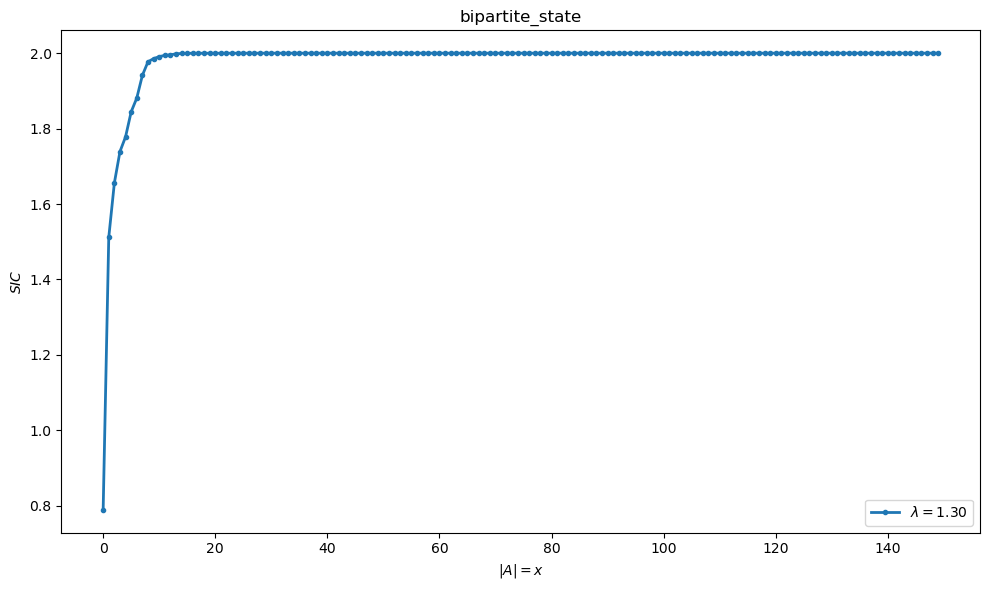

elapsed time: 75.9 s


In [12]:
import tensorcircuit as tc
import numpy as np
import matplotlib.pyplot as plt
import time

K = tc.set_backend("numpy")
tc.set_dtype("complex128")

def gen_H_entangle_nambu(L):  # 这个哈密顿量用于建立参考比特与第 L//2 个 site 的纠缠
    H = np.zeros((2*L+2, 2*L+2), dtype=np.complex128)  # 第 L+1 个 site 是参考比特，python 里的编号是 L

    H[L//2, L] = 1 / 2
    H[L, L//2] = 1 / 2
    H[L//2+L+1, L+L+1] = -1 / 2
    H[L+L+1, L//2+L+1] = -1 / 2

    return H

def gen_H_GAA_nambu(L, t, lbd, a, b, phi):  # 用 Nambu 哈密顿量是因为 tensorcircuit 的 fgs 使用了 Bogoliubov 变换。代入 c 和 Bogoliubov 变换的 alpha 的关系就能得到哈密顿量
    H = np.zeros((2*L+2, 2*L+2), dtype=np.complex128)

    for i in range(L-1):
        H[i, i+1] = t / 2
        H[i+1, i] = t / 2
        H[i+L+1, i+1+L+1] = -t / 2
        H[i+1+L+1, i+L+1] = -t / 2

    for i in range(L):
        H[i, i] = 2 * lbd * np.cos(2*np.pi*i*b+phi) / (1-a*np.cos(2*np.pi*i*b+phi)) / 2
        H[i+L+1, i+L+1] = -H[i, i]

    return H

def cal_SIC_of_x(state_name, L, t, lbd_array, a, b, phi, pre, steps, dt, f):
    H_ent = gen_H_entangle_nambu(L)
    filled_indices = np.arange(0 , L//f)
    # filled_indices = np.arange(L//f, L)
    if np.in1d(L//2, filled_indices) == False:  # 这也是用来建立纠缠的。如果第 L//2 个 site 无占据，则参考比特有占据，反之则无
        filled_indices = np.append(filled_indices, [L])

    if state_name == "bipartite_state":
        SIC_array = np.zeros((len(lbd_array), steps, L//2))
        for i, lbd in enumerate(lbd_array):
            print(f"lbd = {lbd:.2f} ({i + 1} / {len(lbd_array)})")
            
            H_evo = gen_H_GAA_nambu(L, t, lbd, a, b, phi)
            system = tc.FGSSimulator(L+1, filled=filled_indices)
            system.evol_ghamiltonian(2 * H_ent * np.pi/4)
            system.evol_ghamiltonian(2 * H_evo * pre)

            random_array = np.random.rand(steps)
            for j in range(steps):
                for x in range(L//2):
                    E_list = np.arange(L//2-x, L//2+x+1, 1)  # +0.001 使得列表取值能取到后一个数，且数据类型为浮点数，虽然它本身是整数
                    S_E = system.entropy(E_list)
                    S_R = system.entropy([L])
                    S_ER = system.entropy(np.append(E_list, L))
                    # print(S_E, S_R, S_ER)
                    SIC_array[i, j, x] = S_E + S_R - S_ER
                system.evol_ghamiltonian(2 * H_evo * dt * random_array[j])

    file_name = f"4 - SIC_of_x_{state_name}_f_{f}_L_{L}_a_{a:.1f}_lbd_{lbd_array[0]}_{lbd_array[-1]}_pre_{pre}_steps_{steps}_dt_{dt}"
    np.savez("data//" + file_name + ".npz", SIC_array=SIC_array)

def vis_SIC_of_x(state_name, L, lbd_array, a, pre, steps, dt, f):
    file_name = f"4 - SIC_of_x_{state_name}_f_{f}_L_{L}_a_{a:.1f}_lbd_{lbd_array[0]}_{lbd_array[-1]}_pre_{pre}_steps_{steps}_dt_{dt}"
    data = np.load("data//" + file_name + ".npz")
    SIC_array=data['SIC_array']

    plt.figure(figsize=(10, 6))

    for lbd_idx, lbd in enumerate(lbd_array):
        if state_name == "bipartite_state":
            colors = plt.cm.viridis(np.linspace(0, 1, len(lbd_array)))
            plt.plot(range(L//2), np.mean(SIC_array[lbd_idx, :, :] / np.log(2), 0), marker='.', linewidth=2, label=rf"$\lambda={lbd:.2f}$", color=colors[lbd_idx])
            # mean(a, axis=())  # 表示对给定轴求平均值
            # 多维数组，给定其中一个指标，其他全是 : ，则新数组的尺寸为原数组尺寸删掉给定的那个轴
            # 例：a 的尺寸是 (2, 3, 4)，b = a [:, 1, :]，则 b 的尺寸是 (2, 4)

    plt.title(state_name)
    plt.legend()
    plt.xlabel(r'$|A|=x$')
    plt.ylabel(r'$SIC$')
    plt.tight_layout()
    plt.savefig("fig//" + file_name + ".png", dpi=300, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    np.random.seed(123)
    state_name = "bipartite_state"
    f = 2
    L = 300
    t = 1
    # lbd_array = np.concatenate((np.arange(0, 0.5, 0.25), np.arange(0.5, 1.5, 0.1), np.arange(1.5, 2.0+1e-3, 0.25)))
    lbd_array = np.array([1.3])
    a = 0
    b = (np.sqrt(5) - 1) / 2
    phi = np.pi/4
    pre = 10000
    steps = 10
    dt = 10
    
    start_time = time.time()
    cal_SIC_of_x(state_name, L, t, lbd_array, a, b, phi, pre, steps, dt, f)
    vis_SIC_of_x(state_name, L, lbd_array, a, pre, steps, dt, f)
    end_time = time.time()
    print(f"elapsed time: {end_time - start_time:.1f} s")

/tmp/ipykernel_1307789/1213326349.py:35: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  if np.in1d(2*L//2+8, filled_indices) == False:  ########################  # 这也是用来建立纠缠的。如果第 L//2 个 site 无占据，则参考比特有占据，反之则无


lbd = 2.00 (1 / 1)


/tmp/ipykernel_1307789/1213326349.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
  SIC_array[i, j, x] = S_E + S_R - S_ER


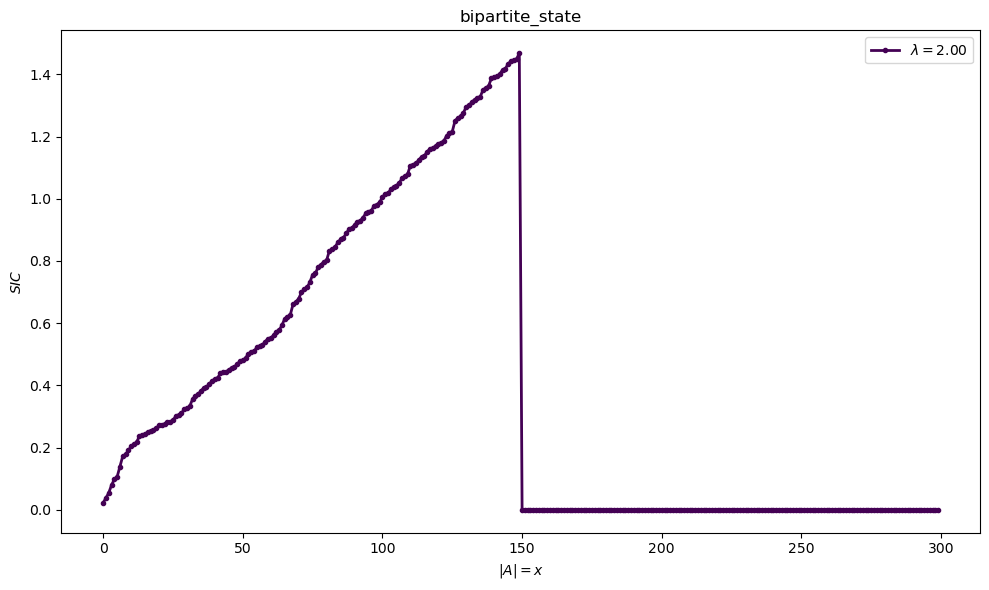

elapsed time: 113.0 s


In [ ]:
def gen_H_entangle(L):
    H = np.zeros((L + 1, L + 1), dtype=np.complex128)

    H[L//2+0, L] = 1
    H[L, L//2+0] = 1  #####################
    return H

def gen_H_Raman_real(L, tso, Mz, beta, t0=1, phi=0):
    Ham = np.zeros((2 * L + 1, 2 * L + 1), dtype=np.complex128)

    for i in range(L - 1):
        Ham[2 * i + 2, 2 * i] = t0  # 0, 2, 4, ... down
        Ham[2 * i + 3, 2 * i + 1] = - t0  # 1, 3, 5, ... up
        Ham[2 * i + 1, 2 * i + 2] = tso
        Ham[2 * i + 3, 2 * i] = - tso

    Ham[0, 2 * (L - 1)] = t0  # PBC条件
    Ham[1, 2 * (L - 1) + 1] = - t0
    Ham[2 * (L - 1) + 1, 0] = tso
    Ham[1, 2 * (L - 1)] = - tso

    Ham += Ham.conj().T  # 加上H.c.

    for i in range(L):  # 准周期势
        Ham[2 * i, 2 * i] = - Mz * np.cos(2 * np.pi * beta * (i + 1) + phi)  # 下标从0开始，但是格点从1开始，所以i + 1
        Ham[2 * i + 1, 2 * i + 1] = Mz * np.cos(2 * np.pi * beta * (i + 1) + phi)

    return Ham


def cal_SIC_of_x(state_name, L, t0, tso, lbd_array, beta, phi, pre, steps, dt, f):
    H_ent = gen_H_entangle(2 * L)
    filled_indices = np.arange(0 , 2*L//f)
    # filled_indices = np.arange(L//f, L)
    if np.in1d(2*L//2+0, filled_indices) == False:  ########################  # 这也是用来建立纠缠的。如果第 L//2 个 site 无占据，则参考比特有占据，反之则无
        filled_indices = np.append(filled_indices, [2*L])

    if state_name != "random_state":
               
        SIC_array = np.zeros((len(lbd_array), steps, 2*L//2))
        for i, lbd in enumerate(lbd_array):
            print(f"lbd = {lbd:.2f} ({i + 1} / {len(lbd_array)})")
            
            H_evo = gen_H_Raman_real(L, tso, lbd, beta, t0, phi)
            system = FreeFermionSystem(2*L + 1, filled=filled_indices)
            system.evol_sys(H_ent, np.pi/4)
            system.evol_sys(H_evo, pre)

            random_array = np.random.rand(steps)
            for j in range(steps):
                for x in range(L//2):
                    E_list = np.arange(2*L//2-x+0, 2*L//2+x+1+0, 1)  #####################
                    S_E = system.entropy(E_list)
                    S_R = system.entropy([2*L])
                    S_ER = system.entropy(np.append(E_list, 2*L))
                    SIC_array[i, j, x] = S_E + S_R - S_ER
                system.evol_sys(H_evo, dt * random_array[j])

    file_name = f"4 - SIC_of_x_{state_name}_f_{f}_L_{L}_lbd_{lbd_array[0]}_{lbd_array[-1]}_pre_{pre}_steps_{steps}_dt_{dt}"
    np.savez("data//" + file_name + ".npz", SIC_array=SIC_array)

def vis_SIC_of_x(state_name, L, lbd_array, pre, steps, dt, f):
    file_name = f"4 - SIC_of_x_{state_name}_f_{f}_L_{L}_lbd_{lbd_array[0]}_{lbd_array[-1]}_pre_{pre}_steps_{steps}_dt_{dt}"
    data = np.load("data//" + file_name + ".npz")
    SIC_array=data['SIC_array']

    plt.figure(figsize=(10, 6))

    for lbd_idx, lbd in enumerate(lbd_array):
        if state_name == "random_state":
            SIC_LTA_array = np.mean(SIC_array, axis=1)
            SIC_RSA_array = np.mean(SIC_LTA_array, axis=2)
            SIC_error_array = [np.sqrt(np.sum((SIC_LTA_array[lbd_idx, i, :] - SIC_RSA_array[lbd_idx, i]) ** 2) / (np.size(SIC_LTA_array, 2) - 1)) for i in range(np.size(SIC_LTA_array, 1))]
            plt.errorbar(range(2*L//2), SIC_RSA_array[lbd_idx, :] / np.log(2), SIC_error_array / np.log(2), linewidth=2, marker='.', label=rf"$\lambda={lbd:.2f}$")
        else:
            colors = plt.cm.viridis(np.linspace(0, 1, len(lbd_array)))
            plt.plot(range(2*L//2), np.mean(SIC_array[lbd_idx, :, :] / np.log(2), 0), marker='.', linewidth=2, label=rf"$\lambda={lbd:.2f}$", color=colors[lbd_idx])

    plt.title(state_name)
    plt.legend()
    plt.xlabel(r'$|A|=x$')
    plt.ylabel(r'$SIC$')
    plt.tight_layout()
    # plt.savefig("fig//" + file_name + ".png", dpi=300, bbox_inches="tight")
    plt.show()


if __name__ == "__main__":
    np.random.seed(123)
    state_name = "bipartite_state"
    f = 2
    L = 300
    t0 = 1
    tso = 0.3
    # lbd_array = np.concatenate((np.arange(0, 0.5, 0.25), np.arange(0.5, 1.5, 0.1), np.arange(1.5, 2.0+1e-3, 0.25)))
    lbd_array = np.array([2.0])
    beta = (np.sqrt(5) - 1) / 2
    phi = np.pi/4
    pre = 10000
    steps = 10
    dt = 10

    start_time = time.time()
    cal_SIC_of_x(state_name, L, t0, tso, lbd_array, beta, phi, pre, steps, dt, f)
    vis_SIC_of_x(state_name, L, lbd_array, pre, steps, dt, f)
    end_time = time.time()
    print(f"elapsed time: {end_time - start_time:.1f} s")

In [ ]:
def gen_H_entangle(L, bias=0):
    H = np.zeros((L + 1, L + 1), dtype=np.complex128)

    H[L//2+bias, L] = 1
    H[L, L//2+bias] = 1  #####################
    return H

def gen_H_Raman_real(L, tso, Mz, beta, t0=1, phi=0):
    Ham = np.zeros((2 * L + 1, 2 * L + 1), dtype=np.complex128)

    for i in range(L - 1):
        Ham[2 * i + 2, 2 * i] = t0  # 0, 2, 4, ... down
        Ham[2 * i + 3, 2 * i + 1] = - t0  # 1, 3, 5, ... up
        Ham[2 * i + 1, 2 * i + 2] = tso
        Ham[2 * i + 3, 2 * i] = - tso

    Ham[0, 2 * (L - 1)] = t0  # PBC条件
    Ham[1, 2 * (L - 1) + 1] = - t0
    Ham[2 * (L - 1) + 1, 0] = tso
    Ham[1, 2 * (L - 1)] = - tso

    Ham += Ham.conj().T  # 加上H.c.

    for i in range(L):  # 准周期势
        Ham[2 * i, 2 * i] = - Mz * np.cos(2 * np.pi * beta * (i + 1) + phi)  # 下标从0开始，但是格点从1开始，所以i + 1
        Ham[2 * i + 1, 2 * i + 1] = Mz * np.cos(2 * np.pi * beta * (i + 1) + phi)

    return Ham


def cal_SIC_of_x(state_name, L, t0, tso, lbd, bias_array, beta, phi, pre, steps, dt, f):
    # filled_indices = np.arange(L//f, L)
    H_evo = gen_H_Raman_real(L, tso, lbd, beta, t0, phi)
    SIC_array = np.zeros((len(bias_array), steps, L//2))

    for i, bias in enumerate(bias_array):
        print(f"bias = {bias:d} ({i + 1} / {len(bias_array)})")
        H_ent = gen_H_entangle(2 * L, bias)
        filled_indices = np.arange(0 , 2*L//f)
        if np.in1d(2*L//2+bias, filled_indices) == False:  ########################  # 这也是用来建立纠缠的。如果第 L//2 个 site 无占据，则参考比特有占据，反之则无
            filled_indices = np.append(filled_indices, [2*L])

        system = FreeFermionSystem(2*L + 1, filled=filled_indices)
        system.evol_sys(H_ent, np.pi/4)
        system.evol_sys(H_evo, pre)

        random_array = np.random.rand(steps)
        for j in range(steps):
            for x in range(L//2):
                E_list = np.arange(2*L//2-x+bias, 2*L//2+x+1+bias, 1)  #####################
                # E_list = np.arange(2*L//2+bias, 2*L//2+x+1+bias, 1)
                S_E = system.entropy(E_list)
                S_R = system.entropy([2*L])
                S_ER = system.entropy(np.append(E_list, 2*L))
                SIC_array[i, j, x] = S_E + S_R - S_ER
            system.evol_sys(H_evo, dt * random_array[j])

    file_name = f"4 - SIC_of_x_{state_name}_f_{f}_L_{L}_lbd_{lbd}_bias_{bias_array[0]}_{bias_array[-1]}_pre_{pre}_steps_{steps}_dt_{dt}"
    np.savez("data//" + file_name + ".npz", SIC_array=SIC_array)

def vis_SIC_of_x(state_name, L, lbd, bias_array, pre, steps, dt, f):
    file_name = f"4 - SIC_of_x_{state_name}_f_{f}_L_{L}_lbd_{lbd}_bias_{bias_array[0]}_{bias_array[-1]}_pre_{pre}_steps_{steps}_dt_{dt}"
    data = np.load("data//" + file_name + ".npz")
    SIC_array=data['SIC_array']

    plt.figure(figsize=(10, 6))

    for idx, bias in enumerate(bias_array):
        if state_name == "random_state":
            SIC_LTA_array = np.mean(SIC_array, axis=1)
            SIC_RSA_array = np.mean(SIC_LTA_array, axis=2)
            SIC_error_array = [np.sqrt(np.sum((SIC_LTA_array[idx, i, :] - SIC_RSA_array[idx, i]) ** 2) / (np.size(SIC_LTA_array, 2) - 1)) for i in range(np.size(SIC_LTA_array, 1))]
            plt.errorbar(range(2*L//2), SIC_RSA_array[idx, :] / np.log(2), SIC_error_array / np.log(2), linewidth=2, marker='.', label=rf"$\lambda={lbd:.2f}$")
        else:
            colors = plt.cm.viridis(np.linspace(0, 1, len(bias_array)))
            plt.plot(range(L//2), np.mean(SIC_array[idx, :, :] / np.log(2), 0), marker='.', linewidth=1, label=rf"$bias={bias:d}$", color=colors[idx])

    plt.title(state_name + rf", $\lambda$={lbd}, L={L}")
    plt.legend()
    plt.xlabel(r'$|A|=x$')
    plt.ylabel(r'$SIC$')
    plt.tight_layout()
    plt.savefig("fig//" + file_name + ".png", dpi=300, bbox_inches="tight")
    plt.show()


if __name__ == "__main__":
    np.random.seed(123)
    state_name = "bipartite_state"
    f = 2
    L = 280
    t0 = 1
    tso = 0.3
    beta = (np.sqrt(5) - 1) / 2
    phi = 0
    pre = 10000
    steps = 10
    dt = 10

    lbd = 2.0
    bias_array = np.arange(0, 104+1, 8)
    # 注意这是单侧的
    start_time = time.time()
    cal_SIC_of_x(state_name, L, t0, tso, lbd, bias_array, beta, phi, pre, steps, dt, f)
    vis_SIC_of_x(state_name, L, lbd, bias_array, pre, steps, dt, f)
    end_time = time.time()
    print(f"elapsed time: {end_time - start_time:.1f} s")